# Alzheimers Prediction - Refactored Approach

_Predicting Cognitively Normal (CN), Mild Cognitive Impairment (MCI), or Alzheimers (AD)_

## Variable Descriptions
* `directory.id`	Id assigned to imaging directories. Not from LONi data
* `Subject (PTID)`	Participant ID
* `RID`	Participant roster ID
* `Image.Data.ID`	MRI ID
* `Modality`	Image type
* `Visit`	1=screening scan
* `Acq.Date`	MRI date
* `DX.bl`	Diagnosis at baseline
* `EXAMDATE`	Examination Date
* `AGE`	    Age at baseline
* `PTGENDER`	Sex
* `PTEDUCAT`	Years of Education
* `PTETHCAT`	Ethnicity
* `PTRACCAT`	Race
* `APOE4`	APOE4 genotype
* `MMSE`	MMSE score on cognitive test
* `imputed_genotype`	Challenge specific designation, TRUE=has imputed genotypes
* `APOE Genotype`	APOE allele 1 and allele 2 genotypes

### Target
* `Dx Codes for Submission`	The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

In [23]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

## Exploration & Pre-processing

In [88]:
df = pd.read_csv('data/challenges/train/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

df.head()

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,9/1/05,AD,9/12/05,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11/8/05,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,9/2/05,CN,9/7/05,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN
3,d8d175ffff1e2053e6a18c5df494ccdf,100_S_0006,6,33025,MRI,1,11/15/05,LMCI,11/29/05,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3",MCI
4,986e75b2e604cd44b38feb2188476fb2,011_S_0010,10,32270,MRI,1,11/7/05,AD,11/10/05,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4",AD


In [89]:
# Small dataset
df.shape

(628, 19)

In [90]:
# Class balance
df['Dx Codes for Submission'].value_counts()

MCI    305
CN     190
AD     133
Name: Dx Codes for Submission, dtype: int64

In [91]:
X = df[['AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'APOE4', 'MMSE', 'APOE Genotype']]
y = df['Dx Codes for Submission']

X.head()

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,"3,4"


In [92]:
X['APOE Genotype'].value_counts()

3,3    276
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64

In [93]:
# No missing values
X.isnull().sum()

AGE              0
PTGENDER         0
PTEDUCAT         0
PTETHCAT         0
PTRACCAT         0
APOE4            0
MMSE             0
APOE Genotype    0
dtype: int64

In [94]:
X['PTGENDER'].value_counts()

Male      364
Female    264
Name: PTGENDER, dtype: int64

Categorical variable distributions:


Distribution of PTGENDER
Male      364
Female    264
Name: PTGENDER, dtype: int64


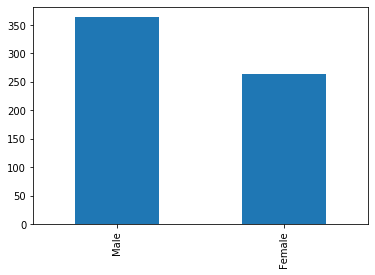


Distribution of APOE4
0    323
1    234
2     71
Name: APOE4, dtype: int64


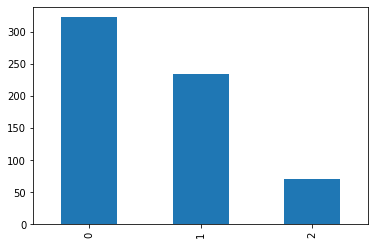


Distribution of APOE Genotype
3,3    276
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64


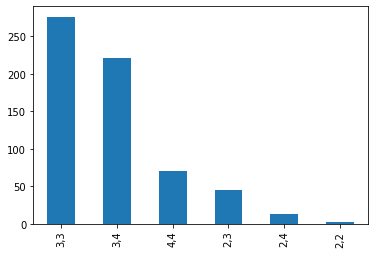


Distribution of PTETHCAT
Not Hisp/Latino    617
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64


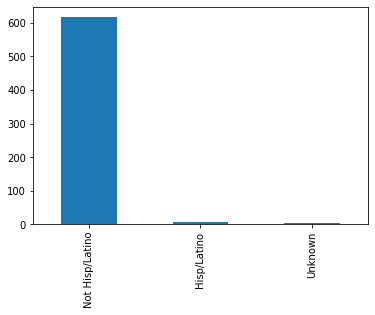


Distribution of PTRACCAT
White    584
Black     31
Asian     13
Name: PTRACCAT, dtype: int64


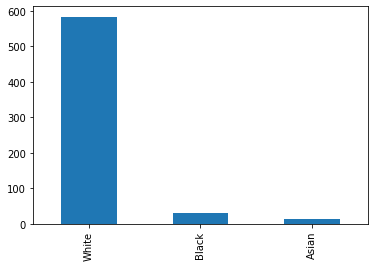

In [95]:
numerical_vars = ['AGE', 'PTEDUCAT', 'MMSE']
cat_vars = list(set(X.columns) - set(numerical_vars))

def eval_cat_vars(X, variables):
    print('Categorical variable distributions:\n')

    for var in variables:
        print('\nDistribution of', var)

        dist = X[var].value_counts()
        print(dist)
        dist.plot(kind='bar')
        plt.show()
        
eval_cat_vars(X, cat_vars)

Numerical Var Distributions:



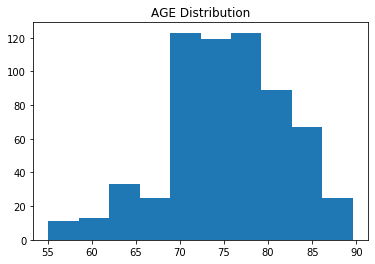

count    628.000000
mean      75.169586
std        6.687429
min       55.100000
25%       71.200000
50%       75.450000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


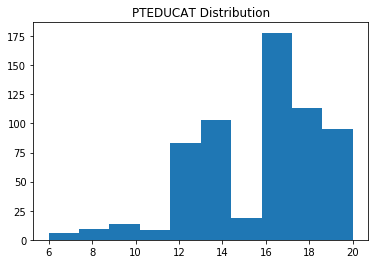

count    628.000000
mean      15.616242
std        2.977993
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


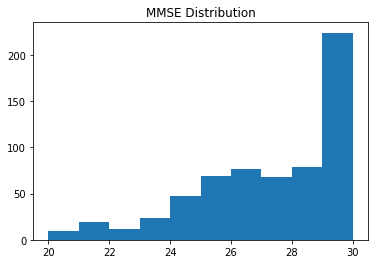

count    628.000000
mean      26.920382
std        2.562152
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


In [96]:
from matplotlib import pyplot as plt
%matplotlib inline

def eval_num_vars(X, variables):
    print('Numerical Var Distributions:\n')

    for var in variables:
        plt.hist(X[var], bins=10)
        plt.title(var + ' Distribution')
        plt.show()

        # descriptive stats
        print(X[var].describe())
        
eval_num_vars(X, numerical_vars)

## Pre-processing

One-hot encode

In [97]:
X.head()

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,"3,4"


In [98]:
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')
    
    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)
    
X.head(4)

Converting PTGENDER to 1-hot encoding
Converting APOE4 to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting PTRACCAT to 1-hot encoding


,AGE,PTEDUCAT,MMSE,Female,Male,0,1,2,"2,2","2,3","2,4","3,3","3,4","4,4",Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White
0,81.3,18,20,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
1,67.5,10,27,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
2,73.7,16,29,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,80.4,13,25,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1


Normalize numerical values [0, 1]

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the data using the scaler
X[['AGE', 'PTEDUCAT', 'MMSE']] = scaler.fit_transform(X[['AGE', 'PTEDUCAT', 'MMSE']])
X.head()

,AGE,PTEDUCAT,MMSE,Female,Male,0,1,2,"2,2","2,3","2,4","3,3","3,4","4,4",Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White
0,0.759420,0.857143,0.0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
1,0.359420,0.285714,0.7,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
2,0.539130,0.714286,0.9,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,0.733333,0.500000,0.5,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
4,0.544928,0.428571,0.4,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1


## Train & Validate

In [100]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split 'test' into validation and test
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('Train set:', X_train.shape)
print('Validation set:', X_valid.shape)
print('Test set:', X_test.shape)

Train set: (502, 20)
Validation set: (63, 20)
Test set: (63, 20)


**Note:** Currently this is a 3-class classification problem. We can also collapse 'CN' and 'MCI' into one class and perform binary classification.

In [101]:
# y = y.replace({
#     'CN': 0,
#     'MCI': 1,
#     'AD': 2
# })

# y.head()

0    2
1    1
2    0
3    1
4    2
Name: Dx Codes for Submission, dtype: int64

In [134]:
# Careful of a little class imbalance
print(y_train.value_counts())
print(y_valid.value_counts())
print(y_test.value_counts())

MCI    244
CN     148
AD     110
Name: Dx Codes for Submission, dtype: int64
MCI    34
CN     17
AD     12
Name: Dx Codes for Submission, dtype: int64
MCI    27
CN     25
AD     11
Name: Dx Codes for Submission, dtype: int64


First, compare a few models with their default hyperparameters.

In [103]:
y_train

332     CN
6       CN
104    MCI
114    MCI
482    MCI
      ... 
71      CN
106    MCI
270     CN
435     CN
102     AD
Name: Dx Codes for Submission, Length: 502, dtype: object

In [102]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = lr.predict(X_valid)

/Users/grantgasser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array(['MCI', 'MCI', 'MCI', 'CN', 'CN', 'CN', 'MCI', 'CN', 'CN', 'AD',
       'CN', 'MCI', 'CN', 'MCI', 'CN', 'MCI', 'MCI', 'MCI', 'MCI', 'AD',
       'MCI', 'MCI', 'AD', 'CN', 'MCI', 'CN', 'MCI', 'CN', 'CN', 'MCI',
       'CN', 'MCI', 'MCI', 'MCI', 'MCI', 'AD', 'MCI', 'MCI', 'AD', 'AD',
       'MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'CN', 'MCI', 'CN', 'AD', 'MCI',
       'AD', 'AD', 'MCI', 'MCI', 'MCI', 'MCI', 'CN', 'MCI', 'CN', 'MCI',
       'MCI', 'CN', 'CN'], dtype=object)

In [116]:
from sklearn.metrics import accuracy_score

lr_accuracy = accuracy_score(y_pred, y_valid)
print(f"Logistic Regression Validation Accuracy: {lr_accuracy:.2%}")

Logistic Regression Validation Accuracy: 69.84%


In [119]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = rf.predict(X_valid)

from sklearn.metrics import accuracy_score

rf_accuracy = accuracy_score(y_pred, y_valid)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.2%}")

Random Forest Validation Accuracy: 73.02%


In [122]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a GradientBoostingClassifier object
gb = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
gb.fit(X_train, y_train)

# Predict the classes of the validation set
y_pred = gb.predict(X_valid)

gb_accuracy = accuracy_score(y_pred, y_valid)
print(f"Boosting Validation Accuracy: {gb_accuracy:.2%}")

XGBoost Validation Accuracy: 74.60%


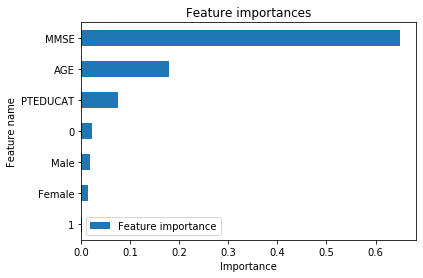

In [128]:
feat_importances = gb.feature_importances_[:7]
feat_names = X_train.columns[:7]
feat_importances_df = pd.DataFrame({'Feature name':feat_names, 'Feature importance':feat_importances})
feat_importances_df.sort_values(by='Feature importance', inplace=True)
feat_importances_df.plot(kind='barh', x='Feature name', y='Feature importance')
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature name')
plt.show()

### Some hyperparemeter tuning

In [129]:
learning_rates = [0.01, 0.05, .1, .2]
n_estimators = [50, 100, 300]
min_samples_splits = [2, 3, 4]
max_depths = [2,3,4,5]
max_features = ['auto', 'sqrt', 'log2']

In [136]:
best_accuracy = float('-inf')
best_hparams = {
    'learning_rate': None,
    'n_estimators': None,
    'min_samples_split': None,
    'max_depth': None,
    'max_features': None
}

for learning_rate in learning_rates:
    for n in n_estimators:
        for min_samples_split in min_samples_splits:
            for max_depth in max_depths:
                for max_feature in max_features:
                    #print(learning_rate, n, min_samples_split, max_depth, max_feature)
                    
                    curr_gb = GradientBoostingClassifier(
                        learning_rate=learning_rate,
                        n_estimators=n,
                        min_samples_split=min_samples_split,
                        max_depth=max_depth,
                        max_features=max_feature,
                        random_state=42
                    )

                    # Fit the model to the training data
                    curr_gb.fit(X_train, y_train)

                    # Predict the classes of the validation set
                    y_pred = curr_gb.predict(X_valid)

                    curr_gb_accuracy = accuracy_score(y_pred, y_valid)
                    
                    if curr_gb_accuracy > best_accuracy:
                        best_accuracy = curr_gb_accuracy
                        best_hparams = {
                            'learning_rate': learning_rate,
                            'n_estimators': n,
                            'min_samples_split': min_samples_split,
                            'max_depth': max_depth,
                            'max_features': max_feature
                        }
                        print(f'New best accuracy: {best_accuracy:.2%} with params: {best_hparams}\n')

New best accuracy: 69.84% with params: {'learning_rate': 0.01, 'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 2, 'max_features': 'auto'}

New best accuracy: 73.02% with params: {'learning_rate': 0.01, 'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 5, 'max_features': 'auto'}

New best accuracy: 76.19% with params: {'learning_rate': 0.01, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'max_features': 'auto'}

New best accuracy: 77.78% with params: {'learning_rate': 0.1, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 2, 'max_features': 'sqrt'}

New best accuracy: 79.37% with params: {'learning_rate': 0.2, 'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 2, 'max_features': 'sqrt'}



Can also use `GridSearchCV`

In [143]:
# Train on best hparams
best_hparams['random_state'] = 42
best_gb = GradientBoostingClassifier(**best_hparams)

# Fit the model to the training data
best_gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=2,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [144]:
from sklearn.metrics import f1_score

# Predict on test set
y_pred = best_gb.predict(X_test)

# Evaluate predictions
test_acc = accuracy_score(y_test, y_pred)
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Test accuracy: ", test_acc)
print("Test weighted F1 score: ", test_f1_weighted)

Test accuracy:  0.6190476190476191
Test weighted F1 score:  0.6142716424631318


## TODO
- [ ] use weighted average F1 rather than accuracy
- [ ] try as a binary classification problem